# 산사태 예측 모델링(LPM:landslide Predict modeling)

<출처 명시>  
스미소니언 보전생물연구소(Smithsonian Conservation Biology Institute) 연구진 분들이 제공한 종 분포 모델링(SDM: Species Distribution Modeling) JavaScript 소스코드 및 
이를 Python 소스코드로 변환한 국립공원공단 유병혁 과장님의 글(pySDM-geemap)을 참고하여 제작한 코드입니다.

- Crego, R. D., Stabach, J. A., & Connette, G. (2022). Implementation of species distribution models in Google Earth Engine. Diversity and Distributions, 28, 904–916. https://doi.org/10.1111/ddi.13491
- https://github.com/osgeokr/pySDM-geemap

- 현재 코드는 전국을 대상으로 예측을 진행하였음 / 권역별(강원권,수도권,호남권,충청권,영남권) 산사태발생 좌표를 입력하여 권역별로 산사태 예측 가능 

In [1]:
import ee
import geemap
import geemap.colormaps as cm
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import os

In [2]:
# Earth Engine 인증
# ee.Authenticate()

# Earth Engine 초기화
ee.Initialize()

In [3]:
# geemap 빈 지도 객체 생성
Map = geemap.Map()

## 1. 과거 산사태 발생 좌표 입력 Landslide data

In [4]:
# 파일 입력
df = pd.read_csv('C:\\Users\\HA\\OneDrive - uos.ac.kr\\바탕 화면\\filtered_landslide_data_20150402_20220802.CSV')
# GeoDataFrame 형식변화
gdf = gpd.GeoDataFrame(df,
                       geometry=gpd.points_from_xy(df['LON_DD'], df['LAT_DD']))

## 2.전처리 Preprocissing

In [5]:
# 전처리 
# 연도 및 달 값 추출 
gdf["year"] = gdf["OCCU_DE"].astype(str)       .str[:4]
gdf["month"] = gdf["OCCU_DE"].astype(str).str[4:6]
gdf = gpd.GeoDataFrame(
    gdf, geometry = gpd.points_from_xy(gdf.LON_DD, gdf.LAT_DD))

# 필요없는 변수 제거
gdf.drop(labels=['fid','field_1','ADRES',
                'RN_ADRES','CTPRVN_CD',	'SGG_CD','EMD_CD','DATA_YR',
                'LON_DMS', 'LAT_DMS', 'X','Y','NM','OCCU_DE',
                 'OBJT_ID'],axis=1,inplace=True)

In [6]:
# 시드 값 설정
random.seed(123)  # 예시로 123 사용 - 항상 동일한값 뽑기 위해

# GeoDataFrame의 크기 계산 / 데이터  크기 줄이기 -> 데이터 크기 클 경우, Google earth engine 계산시간 초과 에러 발생(Computation Timed Out Error)
size = len(gdf) // 80

# 랜덤 샘플 추출 
random_indices = random.sample(range(len(gdf)), size)
gdf = gdf.iloc[random_indices]
len(gdf)

103

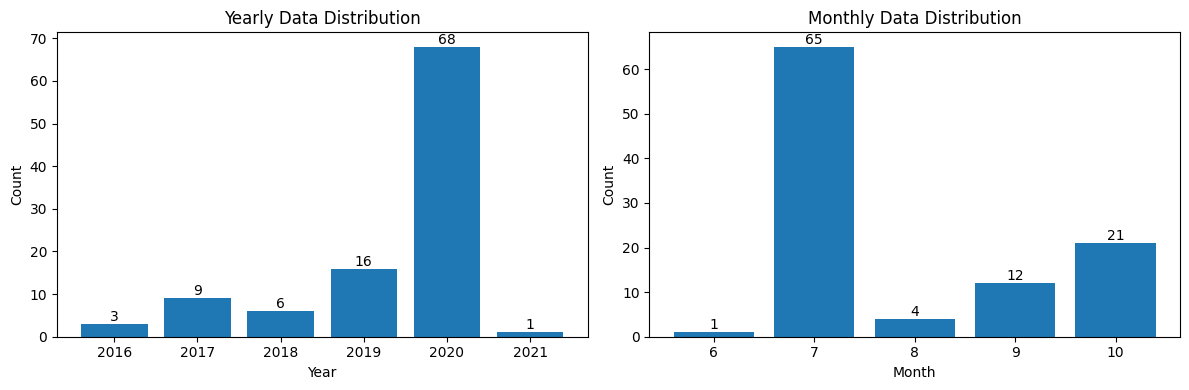

In [7]:
def plot_data_distribution(gdf):
    
    # 연도별 데이터 분포 그래프 (왼쪽)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')

    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')

    # 월별 데이터 분포 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')

    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # x 축의 눈금을 정수 형식으로 설정
    plt.xticks(month_counts.index, map(int, month_counts.index))

    # 그래프 출력
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

plot_data_distribution(gdf)

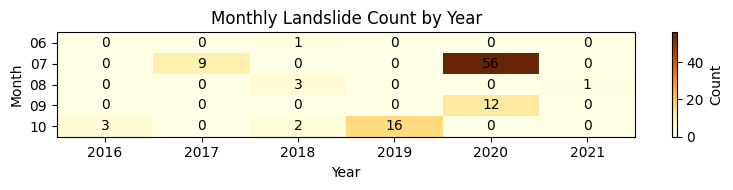

year   2016  2017  2018  2019  2020  2021
month                                    
06        0     0     1     0     0     0
07        0     9     0     0    56     0
08        0     0     3     0     0     1
09        0     0     0     0    12     0
10        3     0     2    16     0     0


In [8]:
def plot_heatmap_from_gdf(gdf):
    # 필요한 통계 계산

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # 히트맵으로 통계 시각화
    plt.figure(figsize=(8, 2))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # 각 픽셀 위에 수치 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Landslide Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()

# 히트맵 그래프 출력 함수 호출
plot_heatmap_from_gdf(gdf)

# 통계 테이블 출력
print(gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

In [9]:
# 필터링된 GeoDataFrame을 Shapefile 형식으로 저장한 다음,
# 다시 Earth Engine의 데이터 형식으로 변환

# 출력 파일 경로
output_shapefile = 'Landslide_data.shp'

# shapefile로 저장
gdf.to_file(output_shapefile)

# 산사태 발생 원시 데이터 추가
data_raw = geemap.shp_to_ee(output_shapefile)

### 2.1 작업할 공간 해상도 설정 ( Grainsize ) - 픽셀당 하나의 자료 추출

→지리적 샘플링 편향을 방지하기 위해 각 픽셀 내에서 발생 기록을 하나만 무작위 선택하여 모델의 예측이 특정 지역에 치우치는 것을 방지

In [10]:
# 작업할 공간 해상도 설정(m) 
GrainSize = 2000   # 메모리 초과 해결방법 -> 공간 해상도 키우기

def remove_duplicates(data, GrainSize):
    # 선택한 공간 해상도(GrainSize = 2KM)에서 픽셀 당 발생 기록 하나만 무작위 선택
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

# 산사태발생위치중 GrainSize 공간해상도 픽셀당 하나만 무작위 선택한 데이터 
Data = remove_duplicates(data_raw, GrainSize)

In [11]:
# 데이터 개수 확인 - 픽셀당 1건 제한 전/후 개수확인
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 103
Final data size: 101


In [12]:
#전처리 전(파란색)
vis_params = {'color': 'blue'}
Map.addLayer(data_raw, vis_params, 'Original data')
Map.centerObject(data_raw.geometry(), 7)
#전처리 후(빨간색)
vis_params = {'color': 'red'}
Map.addLayer(Data, vis_params, 'Final data')
Map.centerObject(Data.geometry(), 7)

Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

### 2.2 관심영역(AOI: Area Of Interest) 설정 – 대한민국 범위

In [13]:
# FAO GAUL: Global Administrative Unit Layers 2015, Country Boundaries
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")

# 'ADM0_NAME' 필드를 기준으로 '대한민국' 필터링
kr = countries.filter(ee.Filter.eq('ADM0_NAME', 'Republic of Korea'))

# 대한민국 경계를 지도에 추가
Map = geemap.Map()
Map.centerObject(kr, 7)  # 경계 중심으로 지도 확대
Map.addLayer(kr, {}, "Republic of Korea")

# 대한민국 경계를 AOI로 설정
AOI = kr.geometry()

# AOI를 지도에 추가
outline = ee.Image().byte().paint(featureCollection=AOI, color=1, width=3)
Map.addLayer(outline, {'palette': 'FF0000'}, "South Korea")

# AOI를 중심으로 지도를 조정
Map.centerObject(AOI, 6)

# 지도 출력
Map


Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

## 3. 예측변수 입력 Predictor variables

Google earth상에서 제공하는 다양한 데이터셋 이용 - 3가지 데이터셋

<변수 설명>

"crops": "경작지로 덮여있을 확률(0~1)"

"water": "수역으로 덮여있을 확률(0~1)"

"trees": "수목으로 덮여있을 확률(0~1)"

"built": "주거·상업·공업지역으로 덮여있을 확률(0~1)"

"grass": "초지로 덮여있을 확률(0~1)"

"aspect": "지형의 경사면이 향하는 방향(동서남북)"

"elevation": "해수면으로부터의 높이를 m 단위로 측정"

"slope": "지표면의 기울기"

"susm": "mm 단위의 지하 토양 수분량"

"VH": "Sentinel-1호(SAR) 위성에서 수직(V) 신호로 방출되고 지구 표면으로부터 수평(H) 신호로 수신되는 신호 방향"

"VV": "Sentinel-1호(SAR) 위성에서 수직(V) 신호로 방출되고 지구 표면으로부터 수직(V) 신호로 수신되는 신호 방향"


In [14]:
# 가져올 기간 선택 
start_date = '2014-01-01'
end_date = '2022-12-31'


# Terrain 객체
# 1) NASA SRTM Digital Elevation 
# 지구 표면의 고도 정보를 제공하며 30m 해상도
#['aspect', 'elevation','hillshade', 'slope'] 4가지 변수중
# ['elevation', 'slope'] 2변수 선택
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))
#.select(['elevation', 'slope'])


# dw_mean 객체 
# 2) Dynamic World V1 Data
# 10m급 Sentinel-2(센티널 2호) 영상에서 딥러닝(deep learning)을 활용하여
# 전세계적으로 일관된 준실시간(NRT: Near Real-Time) 토지이용/피복(LULC: Land Use Land Cover) 분류
# ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice, 'label'중
# [ 'built', 'crops', 'trees', 'water'] 4변수 선택 
dw_col = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
# 가져올 변수 선택
selected_bands = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
# mean -> 기간내 평균값 / 그 지형의 평균적인 경향성 나타냄
dw_mean = dw_col.filterDate(start_date, end_date).select(selected_bands).mean()


# SAR_GRD 객체
# 3) Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling
# C밴드 대역의 sentinel-1호 위성의 신호 방향 ( C밴드 - 숲 캐노피 최상층까지 침투)
# 'VH' : Single co-polarization, horizontal transmit/horizontal receive / 수직(V)으로 방출되고 수평(H) 편파로 수신된 신호 (신호의 방향성)
# mean -> 기간내 평균값 / 그 지형의 평균적인 경향성 나타냄
# ['VH', 'VV', ‘HH’,’HV'] 4가지 변수중
# VH 변수만 선택 
SAR_GRD = ee.ImageCollection("COPERNICUS/S1_GRD") \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .select(['VH','VV']) \
            .mean()


#SMAP_Soil_Moisture 객체 
#4) NASA-USDA Enhanced SMAP Global Soil Moisture Data
#10km 해상도 토양 수분 관측
SMAP_Soil_Moisture = ee.ImageCollection("NASA_USDA/HSL/SMAP_soil_moisture") \
                        .filterDate(start_date, end_date) \
                        .select(['ssm','susm']) \
                        .mean()


# 밴드들을 단일 다중-밴드 이미지로 결합 / predictors에 예측변수들 저장 
predictors = Terrain.addBands(dw_mean).addBands(SAR_GRD).addBands(SMAP_Soil_Moisture)

# 예측 변수 이미지에서 해양 픽셀 마스킹
watermask =  Terrain.select('elevation').gt(0) # 수역 마스크 생성
predictors = predictors.updateMask(watermask).clip(AOI) # 해양 픽셀 마스킹 & 관심 영역 클리핑

In [15]:
# 5000개 임의 지점에서 다중-밴드 예측 이미지 간 공변량 값 추출
DataCor = predictors.sample(scale=GrainSize, numPixels=150, geometries=True) # 100개 임의 지점 생성 
PixelVals = predictors.sampleRegions(collection=DataCor, scale=GrainSize, tileScale=1) # 공변량 값 추출 / 다중공선성 제거 위함

In [16]:
# 공변량 값 ee.featurecollection 타입을 dataframe으로 변환 / 공변량: 독립변수들 간 가지는 변량 
PixelVals_df = geemap.ee_to_pandas(PixelVals)
PixelVals_df.head()

,VH,VV,aspect,bare,built,crops,elevation,flooded_vegetation,grass,hillshade,shrub_and_scrub,slope,snow_and_ice,ssm,susm,trees,water
0,-15.611591,-7.835914,126,0.056992,0.097983,0.200628,183,0.040205,0.082371,172,0.102168,3,0.058626,18.918802,80.294441,0.208311,0.045753
1,-15.170616,-8.520859,285,0.045202,0.046939,0.046912,32,0.036211,0.055796,181,0.069204,0,0.053625,0.635000,4.365001,0.558909,0.044871
2,-14.368921,-8.201681,275,0.066955,0.057460,0.045711,197,0.036506,0.058451,189,0.110251,3,0.056371,17.430368,126.455826,0.482743,0.048952
3,-18.150471,-10.897309,228,0.063339,0.156542,0.227084,42,0.063367,0.068779,181,0.073456,0,0.058730,19.405203,121.120384,0.062785,0.097880
4,-15.094214,-8.747700,272,0.061888,0.071440,0.151804,48,0.040826,0.080456,183,0.113761,1,0.045136,18.442303,79.235802,0.276148,0.048237


In [17]:
# 변수목록 확인 
columns = PixelVals_df.columns
columns

Index(['VH', 'VV', 'aspect', 'bare', 'built', 'crops', 'elevation',
       'flooded_vegetation', 'grass', 'hillshade', 'shrub_and_scrub', 'slope',
       'snow_and_ice', 'ssm', 'susm', 'trees', 'water'],
      dtype='object')

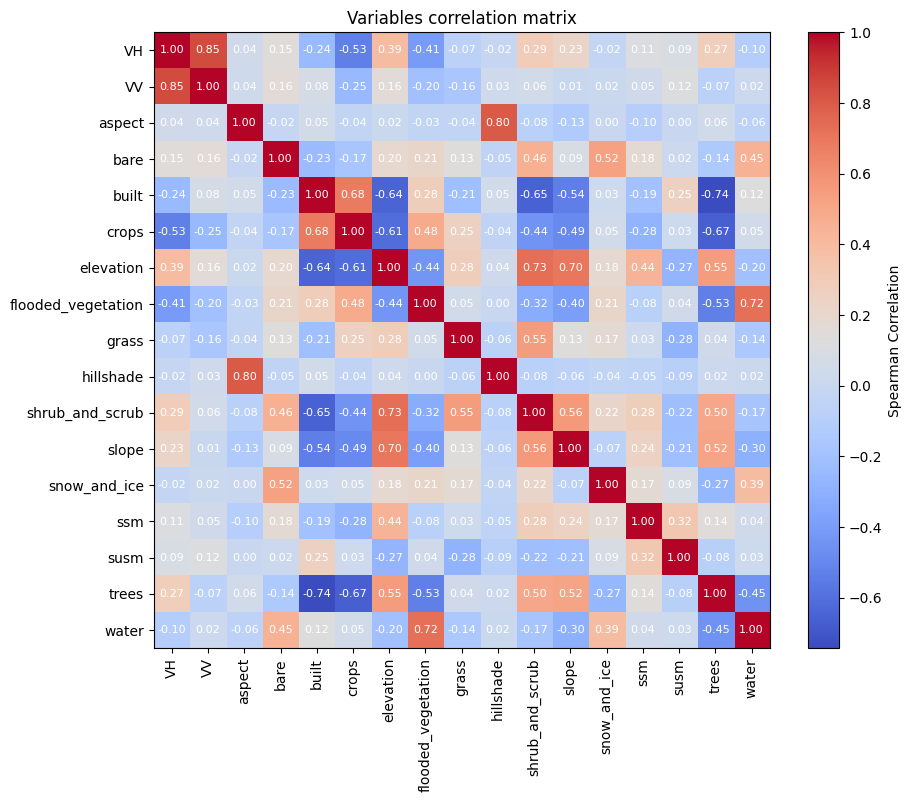

In [18]:
def plot_correlation_heatmap(dataframe, h_size=10):
    # 스피어만 상관계수 계산
    correlation_matrix = dataframe.corr(method="spearman")

    # 히트맵 그리기
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # 히트맵에 수치 표시
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center', color='white', fontsize=8)  # fontsize 조정

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables correlation matrix")
    plt.colorbar(label="Spearman Correlation")
    # plt.savefig('correlation_heatmap_plot.png')
    plt.show()

# 변수 상관행렬 히트맵
plot_correlation_heatmap(PixelVals_df)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def filter_variables_by_vif(dataframe, threshold=10):
    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]

    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)

        if max_vif < threshold:
            break

        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")

        del remaining_columns[max_vif_index]

    filtered_data = dataframe[remaining_columns]
    return filtered_data

# 다중공선성 -> 독립변수간 강한 상관관계 확인
# VIF -> 다중공선성 평가 / 일반적으로 5 or 10보다 클시 강한 상관관계를 가진다고함
# VIF(Variance Inflation Factor, 분산 팽창 요인)로 필터링 수행
# vif 10이상 값 제거 및 남은 Bands(예측변수 확인)
filtered_PixelVals_df = filter_variables_by_vif(PixelVals_df)
bands = filtered_PixelVals_df.columns.tolist()
predictors = predictors.select(bands)
print('최종 변수 Bands:', bands)

# 최종선택된 변수 설명
# "aspect": "지형의 경사면이 향하는 방향(동서남북)"
# "built": "주거·상업·공업지역으로 덮여있을 확률(0~1)"
# "crops": "경작지로 덮여있을 확률(0~1)"
# "elevation": "해수면으로부터의 높이를 m 단위로 측정"
# "slope": "지표면의 기울기"
# "susm": "mm 단위의 지하 토양 수분량"
# "water": "수역으로 덮여있을 확률(0~1)"

Removing 'VH' with VIF 743.99
Removing 'hillshade' with VIF 444.09
Removing 'flooded_vegetation' with VIF 143.29
Removing 'shrub_and_scrub' with VIF 82.51
Removing 'ssm' with VIF 55.24
Removing 'VV' with VIF 33.52
Removing 'bare' with VIF 23.28
Removing 'grass' with VIF 19.17
Removing 'snow_and_ice' with VIF 16.74
Removing 'trees' with VIF 10.19
최종 변수 Bands: ['aspect', 'built', 'crops', 'elevation', 'slope', 'susm', 'water']


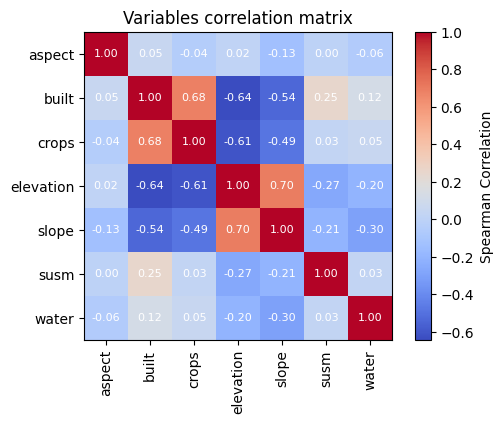

In [20]:
# 남은 변수들 상관행렬 히트맵
plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

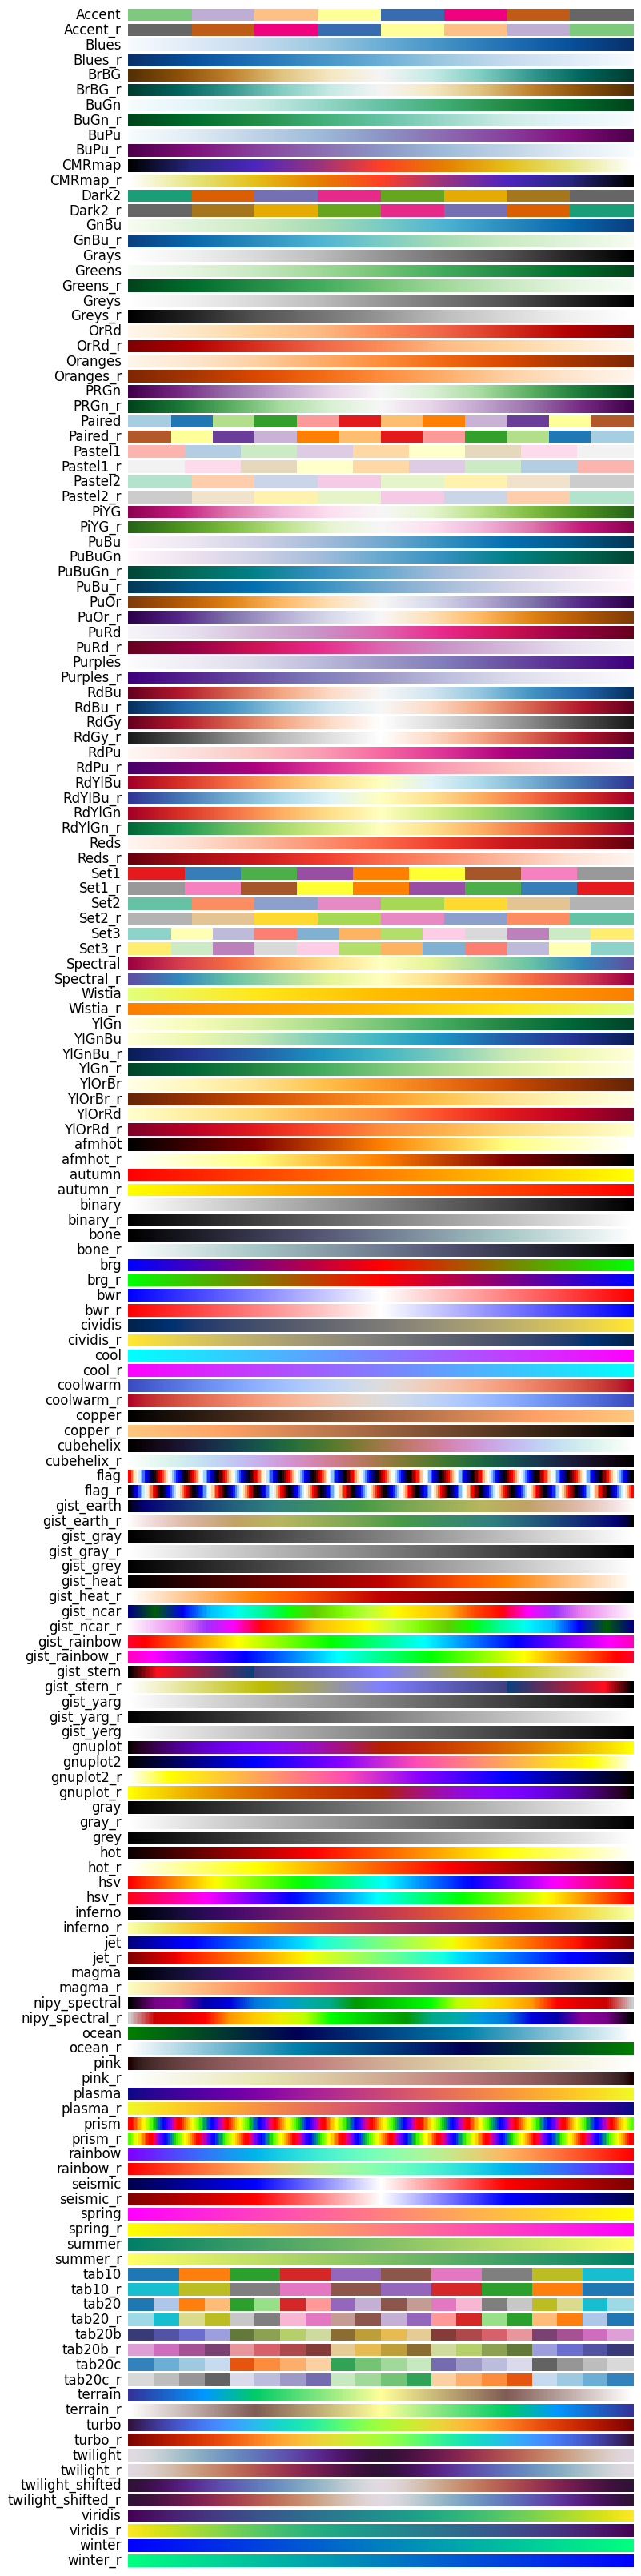

In [21]:
# 다양한 색상맵 확인 
cm.plot_colormaps(width=8.0, height=0.2)

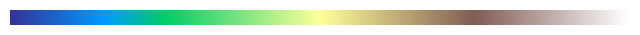

In [22]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

EDA - 최종 선택된 변수별 분포 확인

In [23]:
# aspect
Map = geemap.Map()
vis_params = {'bands':['aspect'], 'min': 0, 'max': 500, 'palette': cm.palettes.copper}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(Data.geometry(), 7)
Map.centerObject(AOI, 7)
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
# Built
Map = geemap.Map()
built_vis_params = {'bands': ['built'], 'min': 0, 'max': 1, 'palette': ['white', 'red']}
Map.addLayer(predictors, built_vis_params, 'Built Area')
Map.add_colorbar(built_vis_params, label="Built Area", orientation="vertical", layer_name="Built Area")
Map.centerObject(AOI, 7)
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [25]:
# Surface Soil Moisture (susm) 시각화 
Map = geemap.Map()
susm_vis_params = {'bands': ['susm'], 'min': 0, 'max': 150, 'palette': ['white', 'green']}
Map.addLayer(predictors, susm_vis_params, 'Surface Soil Moisture')
Map.add_colorbar(susm_vis_params, label="Surface Soil Moisture", orientation="vertical", layer_name="Surface Soil Moisture")
Map.centerObject(AOI, 7)
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [26]:
# Elevation 
Map = geemap.Map()
elevation_vis_params = {'bands': ['elevation'], 'min': 0, 'max': 3000, 'palette': ['white', 'gray', 'black']}
Map.addLayer(predictors, elevation_vis_params, 'Elevation')
Map.add_colorbar(elevation_vis_params, label="Elevation", orientation="vertical", layer_name="Elevation")
Map.centerObject(AOI, 7)
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
# Water
Map = geemap.Map()
water_vis_params = {'bands': ['water'], 'min': 0, 'max': 1, 'palette': ['white', 'blue']}
Map.addLayer(predictors, water_vis_params, 'Water')
Map.add_colorbar(water_vis_params, label="Water", orientation="vertical", layer_name="Water")
Map.centerObject(AOI, 7)
Map

Map(center=[36.34449219000809, 127.80177597242088], controls=(WidgetControl(options=['position', 'transparent_…

## 4.산사태 임의-미발생 데이터 생성 Landslide pseudo- non occurrence

산사태 임의-미발생 영역(pseudo- non occurrence) 정의 -> 변수명 : AreaForPA

3가지 방법 존재

4.1. 전체 관심 영역에서 무작위 임의-비출현 데이터 생성

In [58]:
# 1. 전체 관심 영역에서 무작위 임의-비출현 데이터 생성
# 산사태난 지역 제외 랜덤으로 나머지에서 뽑기
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()
AreaForPA = presence_mask.updateMask(watermask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

4.2 공간 제약된 임의-미발생 데이터 생성(출현 데이터 버퍼)

In [59]:
# 2. 공간 제약된 임의-비출현 데이터 생성(출현 데이터 버퍼)
# 출현지점기준 버퍼영역 설정 후 출현지점 근처의 버퍼영역에서 임의-미발생 데이터 생성
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()
presence_buffer_mask = Data.geometry().buffer(distance=50000, maxError=1000)
AreaForPA = presence_mask.clip(presence_buffer_mask).updateMask(watermask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

4.3 환경적 임의-미발생 데이터 생성(Enviromental profiling)

In [28]:
# 3. 환경적 임의-비출현 데이터 생성(Enviromental profiling)
# 유클리드 거리(Euclidean distance)를 기반으로 k-평균 클러스터링을 통해 2개 클러스터를 생성한 후, 
# 미발생 데이터와 덜 유사하게 분류된 클러스터 내에서 임의-미발생 데이터를 생성하는 방식
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()

# 출현 데이터의 임의 부분집합에서 예측 변수 값 추출
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

# k-평균 클러스터링 훈련
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

# 훈련된 클러스터러를 사용하여 픽셀 할당
Clresult = predictors.cluster(clusterer)

# 출현 데이터와 유사한 클러스터 ID 획득
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)
# 반대 클러스터 사용, 임의-비출현 허용 영역 정의
clustID = ee.FeatureCollection(clustID).reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)
AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)


# 지도출력 
Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

## 5. 모델 적합 Model fitting

5.1 공간 블록 교차-검증용 격자(Grid for spatial block cross-validation) 생성 
- 모델 훈련 및 검증 데이터 분할을 위해

In [29]:
# Grid for spatial block cross-validation 생성
# 공간 블록 교차-검증용 격자 생성
def makeGrid(geometry, scale):
    # 경도 & 위도 도 단위 이미지 생성
    lonLat = ee.Image.pixelLonLat()
    # 경도 & 위도 이미지 정수화
    lonGrid = lonLat.select('longitude').multiply(100000).toInt()
    latGrid = lonLat.select('latitude').multiply(100000).toInt()

    return lonGrid.multiply(latGrid).reduceToVectors(
        # geometry경계 포함 격자 생성
        geometry = geometry.buffer(distance=20000, maxError=1000),
        scale = scale,
        geometryType = 'polygon'
    )

Scale = 50000  # 기존 50000 클수록 / Scale 값이 클수록 해상도가 낮아지며 격자가 더 크게 생성/ 작을수록 더 작은 격자 
grid = makeGrid(AOI, Scale) 

# watermask -> 격자내 블록 평균값 계산, mean값 없는부분 필터링
Grid = watermask.reduceRegions(     
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

#지도출력
Map = geemap.Map()
Map.addLayer(Grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

**훈련 및 검증 데이터 세트를 각각 7:3 비율로 분할**

공간 블록은 보편적으로 모델 적합의 경우 70%, 모델 검증의 경우 30%로 각각 분할됨

In [30]:
split = 0.70  # 공간 블록은 모델 적합의 경우 70%, 모델 검증의 경우 30%로 각각 분할
numiter = 5 # 반복 횟수 (5 or 10 많이 시행)

5.2 모델 적합

In [31]:
def LPM(x):
    Seed = ee.Number(x)

    # 훈련 및 검증을 위한 무작위 블록 분할
    GRID = ee.FeatureCollection(Grid).randomColumn(seed=Seed).sort('random')
    TrainingGrid = GRID.filter(ee.Filter.lt('random', split)) # 훈련용 격자 / split값 기준으로 분할됨
    TestingGrid = GRID.filter(ee.Filter.gte('random', split)) # 시험용 격자 / split값 기준으로 분할됨
    
    # 출현 지점
    PresencePoints = ee.FeatureCollection(Data)
    PresencePoints = PresencePoints.map(lambda feature: feature.set('PresAbs', 1))
    TrPresencePoints = PresencePoints.filter(ee.Filter.bounds(TrainingGrid)) # 훈련용 출현 지점
    TePresencePoints = PresencePoints.filter(ee.Filter.bounds(TestingGrid)) # 검증용 출현 지점
    
    # 임의-비출현 지점
    TrPseudoAbsPoints = AreaForPA.sample(region=TrainingGrid,
                                         scale=GrainSize,
                                         numPixels=TrPresencePoints.size().add(300),
                                         seed=Seed,
                                         geometries=True)
    # 훈련용 출현 지점과 동일한 수의 임의-비출현 지점
    TrPseudoAbsPoints = TrPseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TrPresencePoints.size()))
    TrPseudoAbsPoints = TrPseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))
    
    TePseudoAbsPoints = AreaForPA.sample(region=TestingGrid,
                                         scale=GrainSize,
                                         numPixels=TePresencePoints.size().add(100),
                                         seed=Seed,
                                         geometries=True)
    # 검증용 출현 지점과 동일한 수의 임의-비출현 지점
    TePseudoAbsPoints = TePseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TePresencePoints.size()))
    TePseudoAbsPoints = TePseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    # 훈련 및 임의-비출현 지점 병합
    trainingPartition = TrPresencePoints.merge(TrPseudoAbsPoints) # 훈련용 지점
    testingPartition = TePresencePoints.merge(TePseudoAbsPoints) # 시험용 지점

    # 훈련용 지점에서 예측 변수 이미지의 공변량 값 추출 
    trainPixelVals = predictors.sampleRegions(collection=trainingPartition,
                                              properties=['PresAbs'],
                                              scale=GrainSize,
                                              tileScale=1,
                                              geometries=True)

    # 랜덤 포레스트 분류기(Random Forest classifier)
    Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=100, # 생성할 결정 트리의 수
        variablesPerSplit=None, # 분할당 변수의 수. 기본값: 변수 수의 제곱근 사용
        minLeafPopulation=10, # 훈련 셋에 최소한 이 개수의 지점이 포함된 노드만 생성
        bagFraction=0.5, # 트리당 백에 대한 입력 비율
        maxNodes=None, # 각 트리의 최대 리프 노드 수. 기본값: 제한 없음
        seed=Seed # 무작위화 시드
    )
    #setOutputMode() 함수를 사용하여 
    # PROBABILITY(출현 확률) 및 CLASSIFICATION(이진 출현/비출현 지도)으로 결과를 얻기
    # 출현 확률(Presence probability)
    ClassifierPr = Classifier.setOutputMode('PROBABILITY').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgPr = predictors.select(bands).classify(ClassifierPr)
    
    # 이진 출현/비출현 지도(Binary presence/absence map)
    ClassifierBin = Classifier.setOutputMode('CLASSIFICATION').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgBin = predictors.select(bands).classify(ClassifierBin)
  
    # return ee.List([ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition])
    return [ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition], ClassifierPr

5.3 변수 중요도 계산

In [32]:
results_list = [] # LPM 결과 리스트 초기화
importances_list = [] # 변수 중요도 리스트 초기화

# 랜덤 시드값으로 적용(다른 컴퓨터에서도 동일값 얻기 위해)
for item in [1,2,3,4,5]:
    result, trained = LPM(item)

    # LPM 결과 리스트 누적
    results_list.extend(result)

    # 변수 중요도 리스트 누적
    importance = ee.Dictionary(trained.explain()).get('importance')
    importances_list.extend(importance.getInfo().items())

In [33]:
# LPM 결과 누적
results = ee.List(results_list).flatten()

# 각 변수 중요도 값을 리스트로 추출
variables = [item[0] for item in importances_list]
importances = [item[1] for item in importances_list]

In [34]:
# 변수 중요도 평균 계산
average_importances = {}
for variable in set(variables):
    indices = [i for i, var in enumerate(variables) if var == variable]
    average_importance = np.mean([importances[i] for i in indices])
    average_importances[variable] = average_importance

In [35]:
# 평균 변수 중요도 출력
for variable, avg_importance in average_importances.items():
    print(f"{variable}: {avg_importance}")

susm: 9.26711053482272
crops: 1.5259404472591362
built: 1.9352098421395645
slope: 1.0397914201853853
water: 1.8388461646078291
aspect: 0.7028121610345442
elevation: 7.647081801091194


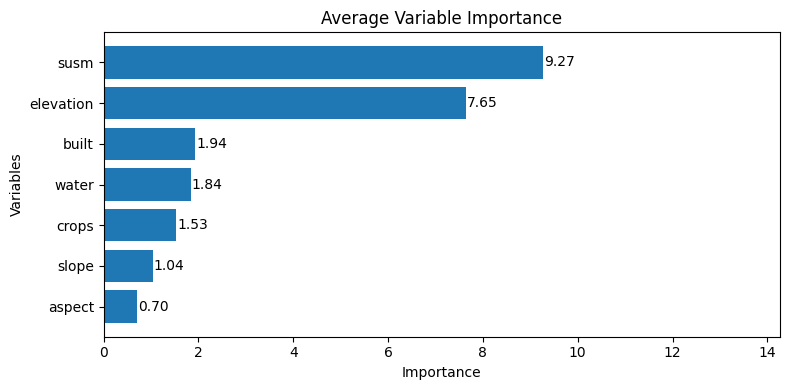

In [36]:
# 변수 중요도가 높은 순으로 정렬
sorted_importances = sorted(average_importances.items(), key=lambda x: x[1], reverse=False)
variables = [item[0] for item in sorted_importances]
avg_importances = [item[1] for item in sorted_importances]

# 그래프 크기 조절
plt.figure(figsize=(8, 4))  # 원하는 크기로 조절

# 막대그래프로 평균 중요도 출력
plt.barh(variables, avg_importances)
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Average Variable Importance')

# 막대 위에 수치 표시
for i, v in enumerate(avg_importances):
    plt.text(v + 0.02, i, f"{v:.2f}", va='center')

# x축 범위 조정
plt.xlim(0, max(avg_importances) + 5)  # 원하는 범위로 조절

plt.tight_layout()
plt.savefig('variable_importance_plot.png')
plt.show()

## 6.모델 예측 Model predictions

**산사태 예측 지도 (Landslide prediction map) 생성 - 2가지 유형**

- 연속된 확률값
- 이진 분류된 범주값

In [37]:
# 산사태 예측 지도(Landslide prediction map) / 확률 연속값 
images = ee.List.sequence(0, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map = geemap.Map()
Map.addLayer(ModelAverage, vis_params, 'Landslide vulnerability')
Map.add_colorbar(vis_params, label="Landslide vulnerability", orientation="horizontal", layer_name="Landslide vulnerability")
Map.addLayer(Data, {'color':'red'}, 'Presence')  # 실제 산사태발생지역
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

In [38]:
# 산사태 예측 지도(Landslide prediction map) / 이진 범주값
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence') # 실제 산사태발생지역
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

## 7.모델 평가 Model evaluation

In [39]:
# 검증용 데이터셋 추출
TestingDatasets = (ee.List.sequence(3, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x)))

# 모델 검증에 충분한 발생 및 임의-미발생 지점이 있는지 확인
def get_sizes(x):
    fc = ee.FeatureCollection(TestingDatasets.get(x))
    presence_size = fc.filter(ee.Filter.eq('PresAbs', 1)).size()
    pseudo_absence_size = fc.filter(ee.Filter.eq('PresAbs', 0)).size()
    return ee.List([presence_size, pseudo_absence_size])


# (출현, 임의-미발생) 개수 쌍으로 출력 
print('Number of presence and pseudo-absence points for model validation',
      ee.List.sequence(0, ee.Number(numiter).subtract(1), 1).map(get_sizes).getInfo())

Number of presence and pseudo-absence points for model validation [[23, 23], [26, 18], [26, 26], [27, 27], [17, 13]]


평가 지표 설정 및 평가

In [40]:
# 민감도(sensitivity), 특이도(specificity), 정밀도(precision) 추정
def getAcc(img, TP, GrainSize=GrainSize):
    Pr_Prob_Vals = img.sampleRegions(collection=TP, properties=['PresAbs'], scale=GrainSize, tileScale=16)   
    seq = ee.List.sequence(start=0, end=1, count=25)
    def calculate_metrics(cutoff):
        Pres = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 1)
        # 민감도(Sensitivity): 진양성(True Positive) 및 진양성율(True Positive Rate)
        TP = ee.Number(Pres.filterMetadata('classification', 'greater_than', cutoff).size())
        TPR = TP.divide(Pres.size())
        Abs = Pr_Prob_Vals.filterMetadata('PresAbs', 'equals', 0)
        
        # 가음성(False Negative)
        FN = ee.Number(Pres.filterMetadata('classification', 'less_than', cutoff).size())
        
        # 특이도(Specificity): 진음성(True Negative) 및 진음성율(True Negative Rate)
        TN = ee.Number(Abs.filterMetadata('classification', 'less_than', cutoff).size())
        TNR = TN.divide(Abs.size())
        
        # 가양성(False Positive) 및 가양성율(False Positive Rate)
        FP = ee.Number(Abs.filterMetadata('classification', 'greater_than', cutoff).size())
        FPR = FP.divide(Abs.size())

        # 정밀도(Precision)
        Precision = TP.divide(TP.add(FP))

        # 민감도(Sensitivity)와 특이도(Specificity)의 합
        SUMSS = TPR.add(TNR)
        
        return ee.Feature(
            None,
            {
                'cutoff': cutoff,
                'TP': TP,
                'TN': TN,
                'FP': FP,
                'FN': FN,
                'TPR': TPR,
                'TNR': TNR,
                'FPR': FPR,
                'Precision': Precision,
                'SUMSS': SUMSS
            }
        )
    return ee.FeatureCollection(seq.map(calculate_metrics))

In [41]:
# AUC-ROC 계산
def getAUCROC(x):
    X = ee.Array(x.aggregate_array('FPR'))
    Y = ee.Array(x.aggregate_array('TPR'))
    X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
    Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
    return X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

def AUCROCaccuracy(x):
  HSM = ee.Image(images.get(x))
  TData = ee.FeatureCollection(TestingDatasets.get(x))
  Acc = getAcc(HSM, TData)
  return getAUCROC(Acc)

AUCROCs = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(AUCROCaccuracy).getInfo() # AUC-ROC
print('AUC-ROC:', AUCROCs)

AUC-ROC: [0.7805383022774327, 0.8588888888888888, 0.7857142857142857, 0.7240802675585284, 0.8487179487179488]


In [42]:
# AUC-PR 계산
def getAUCPR(roc):
    X = ee.Array(roc.aggregate_array('TPR'))
    Y = ee.Array(roc.aggregate_array('Precision'))
    X1 = X.slice(0,1).subtract(X.slice(0,0,-1))
    Y1 = Y.slice(0,1).add(Y.slice(0,0,-1))
    return X1.multiply(Y1).multiply(0.5).reduce('sum',[0]).abs().toList().get(0)

def AUCPRaccuracy(x):
    HSM = ee.Image(images.get(x))
    TData = ee.FeatureCollection(TestingDatasets.get(x))
    Acc = getAcc(HSM, TData)
    return getAUCPR(Acc)
AUCPRs = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(AUCPRaccuracy).getInfo() # AUC-PR
print('AUC-PR:', AUCPRs)

AUC-PR: [0.7093210558122839, 0.8667238455988455, 0.739815102350169, 0.7005739627703663, 0.8692942583732057]


In [43]:
# AUC-ROC 및 AUC-PR 테이블
# 데이터프레임 생성
auc_df = pd.DataFrame({
    'AUC-ROC': AUCROCs,
    'AUC-PR': AUCPRs
}, index=range(1, len(AUCROCs) + 1)) # 인덱스 번호는 1부터 시작

# 평균값 계산 및 마지막 행에 추가
auc_df_average = auc_df.mean().to_frame().T
auc_df_average.index = ['Mean']
auc_df = pd.concat([auc_df, auc_df_average])
auc_df

,AUC-ROC,AUC-PR
1,0.780538,0.709321
2,0.858889,0.866724
3,0.785714,0.739815
4,0.724080,0.700574
5,0.848718,0.869294
Mean,0.799588,0.777146


In [44]:
def getMetrics(x):
    HSM = ee.Image(images.get(x))
    TData = ee.FeatureCollection(TestingDatasets.get(x))
    Acc = getAcc(HSM, TData)
    return Acc.sort('SUMSS', False).first()
Metrics = ee.List.sequence(0,ee.Number(numiter).subtract(1),1).map(getMetrics)

In [45]:
# 민감도(sensitivity: 출현 예측의 정확성)
TPR = ee.FeatureCollection(Metrics).aggregate_array("TPR").getInfo()
print('Sensitivity:', TPR)

Sensitivity: [0.5238095238095238, 0.52, 0.8571428571428571, 0.7391304347826086, 0.6666666666666666]


In [46]:
# 특이도(specificity: 비출현 예측의 정확성)
TNR = ee.FeatureCollection(Metrics).aggregate_array("TNR").getInfo()
print('Specificity:', TNR)

Specificity: [0.9565217391304348, 1, 0.64, 0.6153846153846154, 1]


In [47]:
# Sensitivity 및 Specificity 테이블
# 데이터프레임 생성
metrics_df = pd.DataFrame({
    'Sensitivity': TPR,
    'Specificity': TNR
}, index=range(1, len(TPR) + 1)) # 인덱스 번호는 1부터 시작

# 평균값 계산 및 마지막 행에 추가
metrics_df_average= metrics_df.mean().to_frame().T
metrics_df_average.index = ['Mean']
metrics_df = pd.concat([metrics_df, metrics_df_average])

metrics_df

,Sensitivity,Specificity
1,0.523810,0.956522
2,0.520000,1.000000
3,0.857143,0.640000
4,0.739130,0.615385
5,0.666667,1.000000
Mean,0.661350,0.842381


최적임계값 기반 최종 지도 
1) 연속된 확률값
2) 이진 분류된 범주값

In [48]:
# 최적 임계값 추출
MeanThresh = ee.Number(ee.FeatureCollection(Metrics).aggregate_array("cutoff").reduce(ee.Reducer.mean()))
print('Mean threshold:', MeanThresh.getInfo())

Mean threshold: 0.5083333333333333


In [57]:
# 산사태 위험 지도(Landslide vulnerability map) / 연속된 확률값
# 1) 최적 임계값 기반 마스크 처리된 산사태 위험도 이미지
MeanThresh =  float(MeanThresh.getInfo()) # 'MeanThresh' 부동소수점으로 값 적용
masked_image = ModelAverage.updateMask(ModelAverage.gt(MeanThresh))

# 시각화 매개변수 (임계값 이상 영역에 대한 그라데이션)
vis_params = {
                'min': MeanThresh,  # 최소값을 임계값으로 설정
                'max': 1,          # 최대값
                'palette': ['#00FF00', '#FFFF00', '#FF0000'], # 초록, 노랑, 빨강 순으로 위험
                'opacity' : 0.6,
                'transparent': True,}    
# 지도 생성
Map = geemap.Map()

# 마스크 처리된 산사태 위험도 레이어 추가
Map.addLayer(masked_image, vis_params, 'Landslide Vulnerability (Thresholded)')

# 산사태 실제 발생지역(주황색) 레이어 추가
Map.addLayer(Data, {'color': 'orange'}, 'Presence')

# 범례
legend_dict = {
    'Low Risk': '#00FF00', #초록색
    'Moderate Risk': '#FFFF00', #노란색
    'High Risk': '#FF0000' #빨간색
}

# 컬러바 추가
Map.add_colorbar(vis_params, label="Landslide vulnerability", orientation="horizontal", layer_name="Landslide vulnerability (Thresholded)")

# 지도 중심 설정
Map.centerObject(Data.geometry(), 7)

# 지도 표시
Map


Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

In [50]:
# 2) 산사태 위험 지도(Landslide vulnerability map) / 이진 범주값
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence') # 실제 산사태발생지역
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[36.585540391830854, 128.11321916840834], controls=(WidgetControl(options=['position', 'transparent…

지도그리는데 필요한 객체 pkl파일로 저장 
- 스트림릿(산출물)에 올리기 위함

In [51]:
# import pickle

# # 저장하고자 하는 변수 'data'
# data = MeanThresh  # 최종 임계값 저장

# # .pkl 파일로 저장
# with open('MeanThresh_ver1.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [52]:
# import pickle

# # 저장하고자 하는 변수 'data'
# data = ModelAverage  # 예측된 확률값 저장 

# # .pkl 파일로 저장
# with open('ModelAverage_ver1.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [53]:
# import pickle

# # 저장하고자 하는 변수 'data'
# data = Data  # 전처리된 최종 데이터 저장 

# # .pkl 파일로 저장
# with open('AcuallyData_ver1.pkl', 'wb') as file:
#     pickle.dump(data, file)